In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import re
import spacy

from PIL import Image
from sam2.sam2_image_predictor import SAM2ImagePredictor
from transformers import (
    AutoModelForCausalLM,
    AutoProcessor,
    GenerationConfig,
    BitsAndBytesConfig
)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## SAM2 Helper Functions

In [3]:
# Helper functions for SAM2 segmentation map visualization.
def show_mask(mask, plt, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255/255, 40/255, 50/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    if borders:
        import cv2
        contours, _ = cv2.findContours(
            mask,cv2.RETR_EXTERNAL, 
            cv2.CHAIN_APPROX_NONE
        )
        # Try to smooth contours
        contours = [
            cv2.approxPolyDP(
                contour, epsilon=0.01, closed=True
            ) for contour in contours
        ]
        mask_image = cv2.drawContours(
            mask_image, 
            contours, 
            -1, 
            (1, 0, 0, 1), 
            thickness=2
        ) 
    plt.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(
        pos_points[:, 0], 
        pos_points[:, 1], 
        color='green', 
        marker='.', 
        s=marker_size, 
        edgecolor='white', 
        linewidth=1.25
    )
    ax.scatter(
        neg_points[:, 0], 
        neg_points[:, 1], 
        color='red', 
        marker='.', 
        s=marker_size, 
        edgecolor='white', 
        linewidth=1.25
    )   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle(
        (x0, y0), 
        w, 
        h, 
        edgecolor='green', 
        facecolor=(0, 0, 0, 0), 
        lw=2)
    )    

def show_masks(
    image, 
    masks, 
    scores, 
    point_coords=None, 
    box_coords=None, 
    input_labels=None, 
    borders=True
):
    dpi = plt.rcParams['figure.dpi']
    figsize = image.shape[1] / dpi, image.shape[0] / dpi
    plt.figure(figsize=figsize)
    plt.imshow(image)
    for i, (mask, score) in enumerate(zip(masks, scores)):
        if i == 0:  # Only show the highest scoring mask.
            show_mask(mask, plt, random_color=False, borders=borders)
    if point_coords is not None:
        assert input_labels is not None
        show_points(point_coords, input_labels, plt.gca())
    if box_coords is not None:
        show_box(box_coords, plt.gca())
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.axis('off')
    plt.savefig('figure.png')
    return plt

In [4]:
predictor = SAM2ImagePredictor.from_pretrained('facebook/sam2.1-hiera-tiny')

## Integrate Molmo

In [5]:
# Load Molmo model and processor.
quant_config = BitsAndBytesConfig(
    load_in_4bit=True
)

# load the processor
processor = AutoProcessor.from_pretrained(
    'allenai/MolmoE-1B-0924',
    trust_remote_code=True,
    device_map='auto',
    torch_dtype='auto'
)

# load the model
model = AutoModelForCausalLM.from_pretrained(
    'allenai/MolmoE-1B-0924',
    trust_remote_code=True,
    offload_folder='offload',
    quantization_config=quant_config,
    torch_dtype='auto'
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPTNeoXTokenizer'. 
The class this function is called from is 'GPT2TokenizerFast'.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [7]:
# Load the Spacy model to extract Nouns from Molmo's alt tags.
nlp = spacy.load('en_core_web_sm')

In [13]:
def draw_point_and_show(image_path=None, points=None):
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    for point in points:
        image = cv2.circle(
            image, 
            (point[0], point[1]), 
            radius=5, 
            color=(0, 255, 0), 
            thickness=5,
            lineType=cv2.LINE_AA
        )

    plt.imshow(image[..., ::-1])
    plt.axis('off')
    plt.show()

def get_coords(output_string, image_path):
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    
    if 'points' in output_string:
        # Handle multiple coordinates
        matches = re.findall(r'(x\d+)="([\d.]+)" (y\d+)="([\d.]+)"', output_string)
        coordinates = [(int(float(x_val)/100*w), int(float(y_val)/100*h)) for _, x_val, _, y_val in matches]
    else:
        # Handle single coordinate
        match = re.search(r'x="([\d.]+)" y="([\d.]+)"', output_string)
        if match:
            coordinates = [(int(float(match.group(1))/100*w), int(float(match.group(2))/100*h))]
            
    return coordinates

# Helper function to extract Noun from Molmo alt tags.
def get_nouns(molmo_output=None):
    if 'alt=\"' in molmo_output:
        match = re.search(r'alt="([^"]*)"', molmo_output)
        if match:
            alt_tag = match.group(1)

        doc = nlp(alt_tag)
        nouns = [token.text for token in doc if token.pos_ == 'NOUN']

    print(nouns)
    return nouns

In [9]:
def get_output(image_path=None, prompt='Describe this image.'):
    # process the image and text
    if image_path:
        inputs = processor.process(
            images=[Image.open(image_path)],
            text=prompt
        )
    else:
        inputs = processor.process(
            images=[Image.open(requests.get('https://picsum.photos/id/237/536/354', stream=True).raw)],
            text=prompt
        )

    # move inputs to the correct device and make a batch of size 1
    inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

    # generate output; maximum 200 new tokens; stop generation when <|endoftext|> is generated
    output = model.generate_from_batch(
        inputs,
        GenerationConfig(max_new_tokens=200, stop_strings='<|endoftext|>'),
        tokenizer=processor.tokenizer
    )

    # only get generated tokens; decode them to text
    generated_tokens = output[0,inputs['input_ids'].size(1):]
    generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # print the generated text
    print(generated_text)
    return generated_text


## Integrate CLIP and Segment

In [76]:
def segment(image_path, prompt=None):
    outputs = get_output(image_path=image_path, prompt=prompt)

    coords = get_coords(outputs, image_path=image_path)

    print(f"Coords: {coords}")

    draw_point_and_show(image_path, coords)

    input_points = np.array(coords)
    input_labels = np.ones(len(input_points), dtype=np.int32)
    print(f"Input points: {input_points}, input labels: {input_labels}")

    # For every input point and input label, instead if passing them all at once,
    # pass them one by one to SAM with the Noun list.
    nouns = get_nouns(outputs)
    
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    predictor.set_image(image)

    # This probably takes as many times longer as the number of objects
    # detected by Molmo.
    for input_point, input_label in zip(input_points, input_labels):
        masks, scores, logits = predictor.predict(
            point_coords=[input_point],
            point_labels=[input_label],
            multimask_output=True
        )
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]
        scores = scores[sorted_ind]
        logits = logits[sorted_ind]

        print(f"Masks: {masks}")
        print(f"Mask shape: {masks.shape}")
        print(f"Scores: {scores}")
        print(f"Logits shape: {logits.shape}")
    
        masks_copy = masks.copy()
        masks_copy = masks_copy.transpose(1, 2, 0)
        h, w, _ = masks_copy.shape
        plt.imshow(masks_copy[:, :, 0].astype(np.uint8))
        plt.show()
        
        masked_image = image * np.expand_dims(masks_copy[:, :, 0], axis=-1)
        plt.imshow(masked_image)
        plt.show()
        plt.axis('off')
        # break

    # show_masks(image, masks, scores, point_coords=input_points, input_labels=input_labels, borders=True)

 <points x1="33.6" y1="47.9" x2="59.6" y2="65.6" x3="79.6" y3="48.2" alt="giraffes and the woman.">giraffes and the woman.</points>
Coords: [(215, 459), (381, 629), (509, 462)]


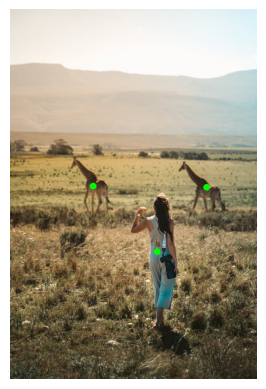

Input points: [[215 459]
 [381 629]
 [509 462]], input labels: [1 1 1]
['giraffes', 'woman']
Masks: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
Mask shape: (3, 960, 640)
Scores: [0.88887477 0.71895313 0.28388932]
Logits shape: (3, 256, 256)


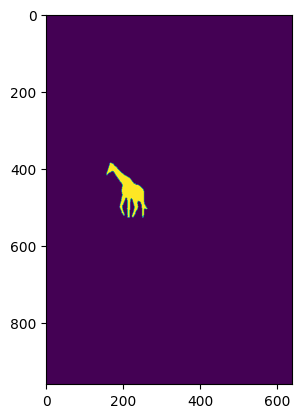

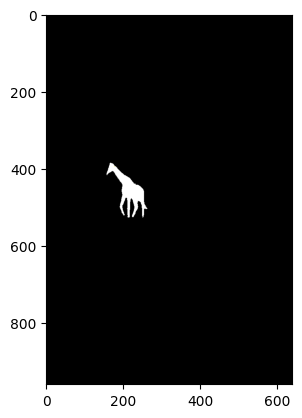

Masks: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
Mask shape: (3, 960, 640)
Scores: [0.90621036 0.47182587 0.3849256 ]
Logits shape: (3, 256, 256)


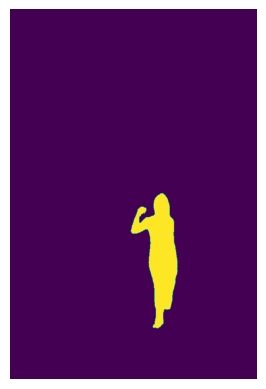

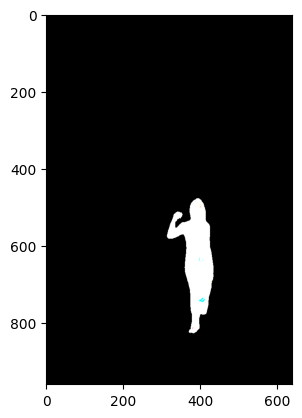

Masks: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
Mask shape: (3, 960, 640)
Scores: [0.9291844  0.722051   0.45142388]
Logits shape: (3, 256, 256)


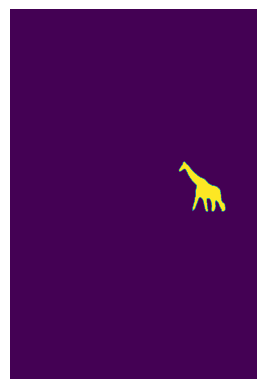

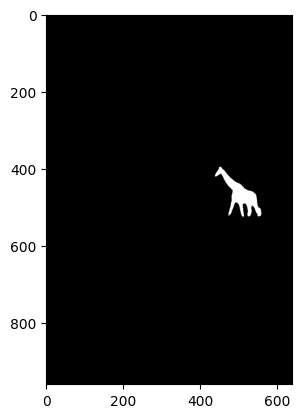

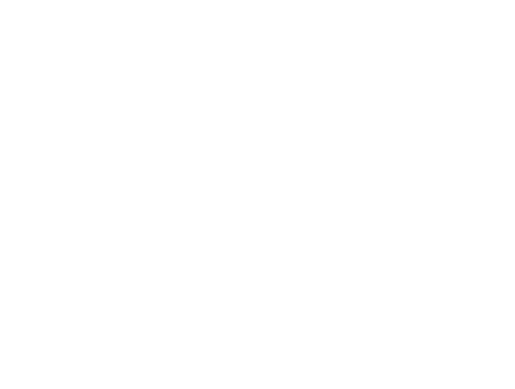

In [77]:
segment(
    image_path='../demo_data/image_4.jpg', 
    prompt='Point to the giraffes and the woman.'
)